# About DeepCoNN

Original work: https://arxiv.org/pdf/1701.04783

Reference iteration: https://towardsdatascience.com/joint-deep-modeling-of-users-and-items-using-reviews-for-recommendation-50e75d5e10aa

The objective of Deep Cooperation Neural Network is to take learnings from both user and item reviews. However, we wanted to experiment with **item descriptions** instead as we believe they serve the same purpose of helping the model to learn the properties of items. As such, our version is slightly different from that of the paper.

**Environment needed**: We used T4 GPU at High RAM and A100 GPU, the testing portion crashed a few times because of the RAM usage and we weren't sure how to fix it. Sorry if it crashes for you!

## Import packages & set-up

In [ ]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score
import tensorflow as tf
import torch


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BT4222 Project/EDA/datasets to submit/bt4222_dataset_21.csv')

### Parameters setting

In [ ]:
FILTERS = 25
DROPOUT = 0.5
EMBED_DIM = 32
MAX_LENGTH = 30
LR = 0.001

## Processing dataframe

In [ ]:
# get relevant columns and rename
df = df[['review_text_clean', 'author.steamid', 'app_id', 'game_description', 'pred_rating', 'timestamp_updated']]
df = df.rename(columns={
    'review_text_clean': 'user_review',
    'author.steamid': 'user_id',
    'app_id': 'item_id',
    'game_description': 'item_description',
    'pred_rating': 'rating',
    'timestamp_updated': 'timestamp_updated'
})

# remove any null just in case
df = df[df['user_review'].str.strip().astype(bool)]

In [ ]:
df['user_review'] = df['user_review'].apply(lambda x: x.lower())
df['item_description'] = df['item_description'].apply(lambda x: x.lower())

### Get Word2Vec for embedding reviews and game descriptions

In [ ]:
rev_desc = df['user_review'].tolist() + df['item_description'].tolist()
tokenized_text = [text.split() for text in rev_desc]

# train Word2Vec model
word2vec = Word2Vec(sentences=tokenized_text, vector_size=EMBED_DIM, window=5, min_count=1, workers=4)

# convert text to sequences of embeddings
def get_embedding_matrix(text, max_length=MAX_LENGTH):
    tokens = text.split()
    embeddings = [word2vec.wv[word] if word in word2vec.wv else np.zeros(EMBED_DIM) for word in tokens]
    return pad_sequences([embeddings], maxlen=max_length, dtype='float32')[0]

# get embedding matrices for user rev and item desc
df['user_matrix'] = df['user_review'].apply(get_embedding_matrix)
df['item_matrix'] = df['item_description'].apply(get_embedding_matrix)


In [ ]:
# check shape of embeddings
user_matrix_shapes = df['user_matrix'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None).unique()
item_matrix_shapes = df['item_matrix'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None).unique()

print("User Matrix Shapes:", user_matrix_shapes)
print("Item Matrix Shapes:", item_matrix_shapes)

User Matrix Shapes: [(30, 32)]
Item Matrix Shapes: [(30, 32)]


In [ ]:
# train-test split is time-aware
df.sort_values(by='timestamp_updated', inplace=True)
df = df.sort_values(['user_id', 'timestamp_updated']).reset_index(drop=True)

train_list = []
val_list = []
test_list = []

# split interactions chronologically
for idx, user_data in df.groupby('user_id'):
    n = len(user_data)

    # get indices for train, val, test splits
    train_end = int(0.8 * n)
    val_end = int(0.9 * n)
    train_list.append(user_data.iloc[:train_end])
    val_list.append(user_data.iloc[train_end:val_end])
    test_list.append(user_data.iloc[val_end:])

# make df's
df_train = pd.concat(train_list).reset_index(drop=True)
df_val = pd.concat(val_list).reset_index(drop=True)
df_test = pd.concat(test_list).reset_index(drop=True)

# check shapes
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")


Training set size: 98950
Validation set size: 12108
Test set size: 15056


In [ ]:
# stack embeddings to form matrices of train, test and val
X_user_train = np.stack(df_train['user_matrix'].values.flatten())
X_item_train = np.stack(df_train['item_matrix'].values.flatten())
y_train = df_train['rating'].values

X_user_val = np.stack(df_val['user_matrix'].values.flatten())
X_item_val = np.stack(df_val['item_matrix'].values.flatten())
y_val = df_val['rating'].values

X_user_test = np.stack(df_test['user_matrix'].values)
X_item_test = np.stack(df_test['item_matrix'].values)
y_test = df_test['rating'].values

# check shape
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 98950
Validation set size: 12108
Test set size: 15056


## Model generation

Over here, we construct the neural network. The first section is running item and user embeddings through a network. From which, the model learns the item and user properties. After which, the output is then used to make a prediction of the rating of a given game and user.

Below is a diagram illustrating the model, taken from the research article linked above: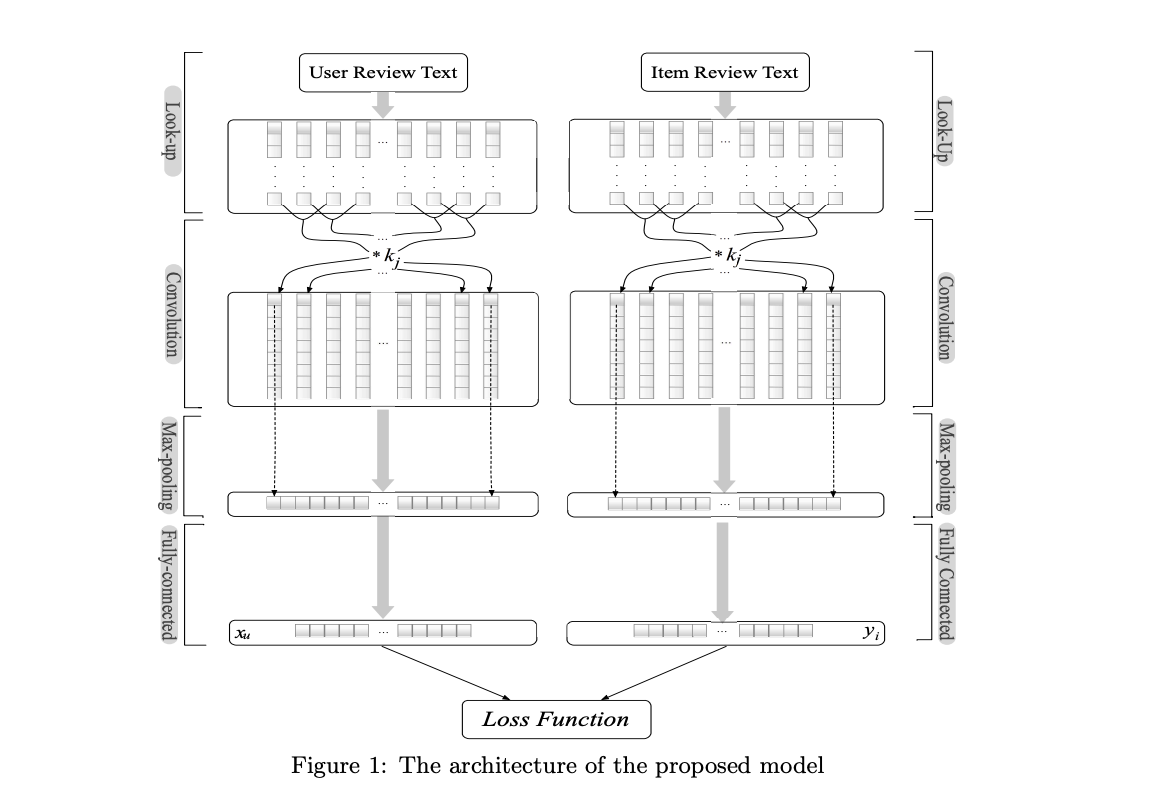


In [ ]:
# network for input matrices
def create_network(input_layer):
    # convolution layer with 50 filters, kernel size 5 with ReLu
    x = Conv1D(FILTERS, 5, activation='relu')(input_layer)
    # pool with size 2
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    # fully connected layer with 32 neurons and ReLu
    x = Dense(32, activation='relu')(x)
    # prevent overfitting with dropout
    x = Dropout(DROPOUT)(x)
    return x

# get networks out of embeddings via neural network
user_input = Input(shape=(MAX_LENGTH, EMBED_DIM), name='user_input')
item_input = Input(shape=(MAX_LENGTH, EMBED_DIM), name='item_input')
user_network = create_network(user_input)
item_network = create_network(item_input)

# get combined feature vector z-hat (based on article)
z_hat = Concatenate()([user_network, item_network])

# get linear term
linear_out = Dense(1)(z_hat)

# combine linear term with dot product of user and item networks
dot_product = Add()([linear_out, Dense(1)(user_network), Dense(1)(item_network)])

# finalise model
model = Model(inputs=[user_input, item_input], outputs=dot_product)
model.compile(optimizer=Adam(learning_rate=LR), loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 30, 32)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 30, 32)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 26, 25)         │          4,025 │ user_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 26, 25)         │          4,025 │ item_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 13, 25)         │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 13, 25)         │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 325)            │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 325)            │              0 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │         10,432 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │         10,432 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64)             │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             33 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             33 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1)              │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0],         │
│                           │                        │                │ dense_4[0][0]          │
└──────────────────────

 Total params: 29,045 (113.46 KB)

 Trainable params: 29,045 (113.46 KB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [ ]:
model.fit([X_user_train, X_item_train], y_train, epochs=10, batch_size=64, validation_data=([X_user_val, X_item_val], y_val))

Epoch 1/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 8.3623 - val_loss: 1.9162
Epoch 2/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.9403 - val_loss: 1.8453
Epoch 3/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.8383 - val_loss: 1.7652
Epoch 4/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7864 - val_loss: 1.7331
Epoch 5/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7271 - val_loss: 1.6752
Epoch 6/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6764 - val_loss: 1.7021
Epoch 7/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6420 - val_loss: 1.6671
Epoch 8/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6011 - val_loss: 1.6150
Epoch 9/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5907 - val_loss: 1.6211
Epoch 10/10
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5540 - val_loss: 1.6430


### Model evaluation - F1 score, Recall, Precision and NDCG where @ K = 4

In [ ]:
def evaluate_model(X_user_test, X_item_test, y_test, model, top_n=4):
    # get predictions from model
    y_pred = model.predict([X_user_test, X_item_test])
    y_pred = y_pred.flatten()
    precisions, recalls, ndcgs = [], [], []
    # get users in test set
    unique_users = np.unique(df_test['user_id'])

    for user_id in unique_users:
        # get user data by getting bool value
        user_indices = df_test['user_id'] == user_id
        user_data = X_user_test[user_indices]
        item_data = X_item_test[user_indices]

        # ground truth
        true_relevance = y_test[user_indices]

        # predict ratings for this user's items
        user_predicted_ratings = model.predict([user_data, item_data]).flatten()

        # get indices of the top N items with highest predicted ratings
        top_n_indices = np.argsort(user_predicted_ratings)[::-1][:top_n]

        # get precision, recall, and NDCG
        precision = precision_score(true_relevance[top_n_indices], np.ones(len(top_n_indices)), zero_division=1, average='micro')
        recall = recall_score(true_relevance[top_n_indices], np.ones(len(top_n_indices)), zero_division=1, average='micro')
        ndcg = np.sum([1 / np.log2(i + 2) for i in range(len(top_n_indices)) if true_relevance[top_n_indices[i]] > 0])

        # append to overall
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_ndcg = np.mean(ndcgs)
    avg_f1 = (2*avg_precision*avg_recall)/(avg_precision+avg_recall)

    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"NDCG: {avg_ndcg:.4f}")
    print(f"F1: {avg_f1:.4f}")

evaluate_model(X_user_test, X_item_test, y_test, model, top_n=4)

471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━

**Final results:**
Precision: 0.0300
Recall: 0.0300
NDCG: 1.8460
F1: 0.0300